In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Imports & Setup

In [11]:
# ══════════════════════════════════════════════════════════
# CELL 0: Install Dependencies (Run this first!)
# ══════════════════════════════════════════════════════════

!pip install -q sacrebleu rouge-score sentencepiece
print("✓ Dependencies installed!")

✓ Dependencies installed!


In [12]:
# ══════════════════════════════════════════════════════════
# CELL 1: Imports & Setup
# ══════════════════════════════════════════════════════════

import os
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import sentencepiece as spm
import sacrebleu
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# Verify files exist
print("\nChecking files...")
print(f"BPE models: {os.path.exists('/kaggle/input/en-gu-bpe-tokenizers/en_bpe.model')}")
print(f"Samanantar: {os.path.exists('/kaggle/input/samanantar/final_data/en-gu/train.en')}")

Using device: cuda

Checking files...
BPE models: True
Samanantar: True


# Load Data & Tokenizers

In [13]:
# ══════════════════════════════════════════════════════════
# CELL 2: Load Data & Pre-trained BPE Tokenizers
# ══════════════════════════════════════════════════════════

# Load BPE tokenizers (trained locally)
en_sp = spm.SentencePieceProcessor(model_file="/kaggle/input/en-gu-bpe-tokenizers/en_bpe.model")
gu_sp = spm.SentencePieceProcessor(model_file="/kaggle/input/en-gu-bpe-tokenizers/gu_bpe.model")

# Special token IDs
PAD_ID = 0
UNK_ID = 1
BOS_ID = 2
EOS_ID = 3

print(f"English vocab size: {en_sp.GetPieceSize()}")
print(f"Gujarati vocab size: {gu_sp.GetPieceSize()}")

# Load training data from Samanantar
EN_FILE = '/kaggle/input/samanantar/final_data/en-gu/train.en'
GU_FILE = '/kaggle/input/samanantar/final_data/en-gu/train.gu'

print("\nLoading training data...")
with open(EN_FILE, 'r', encoding='utf-8') as f:
    english_sentences = [line.strip() for line in f.readlines()]
with open(GU_FILE, 'r', encoding='utf-8') as f:
    gujarati_sentences = [line.strip() for line in f.readlines()]

print(f"Total sentences loaded: {len(english_sentences)}")

# Filter and sample
MAX_CHAR_LENGTH = 200
TOTAL_SAMPLES = 300000

valid_pairs = []
for en, gu in zip(english_sentences, gujarati_sentences):
    if 0 < len(en) < MAX_CHAR_LENGTH and 0 < len(gu) < MAX_CHAR_LENGTH:
        valid_pairs.append((en, gu))
    if len(valid_pairs) >= TOTAL_SAMPLES:
        break

print(f"Valid sentence pairs: {len(valid_pairs)}")

# Shuffle with same seed as local
random.seed(SEED)
random.shuffle(valid_pairs)

# Split
VAL_SIZE = 15000
train_pairs = valid_pairs[:-VAL_SIZE]
val_pairs = valid_pairs[-VAL_SIZE:]

train_en = [p[0] for p in train_pairs]
train_gu = [p[1] for p in train_pairs]
val_en = [p[0] for p in val_pairs]
val_gu = [p[1] for p in val_pairs]

print(f"Training samples: {len(train_en)}")
print(f"Validation samples: {len(val_en)}")

# Test tokenizer
test_en = "Hello, how are you today?"
print(f"\nTokenizer test: '{test_en}' → {en_sp.Encode(test_en)}")

English vocab size: 16000
Gujarati vocab size: 16000

Loading training data...
Total sentences loaded: 3054273
Valid sentence pairs: 300000
Training samples: 285000
Validation samples: 15000

Tokenizer test: 'Hello, how are you today?' → [11758, 15911, 15929, 564, 104, 114, 1467, 15948]


# Dataset & DataLoader

In [14]:
# ══════════════════════════════════════════════════════════
# CELL 3: Dataset & DataLoader
# ══════════════════════════════════════════════════════════

MAX_SEQ_LENGTH = 128
BATCH_SIZE = 64

class TranslationDataset(Dataset):
    def __init__(self, src_sentences, tgt_sentences, src_sp, tgt_sp, max_len=MAX_SEQ_LENGTH):
        self.src_sentences = src_sentences
        self.tgt_sentences = tgt_sentences
        self.src_sp = src_sp
        self.tgt_sp = tgt_sp
        self.max_len = max_len
    
    def __len__(self):
        return len(self.src_sentences)
    
    def __getitem__(self, idx):
        src_text = self.src_sentences[idx]
        tgt_text = self.tgt_sentences[idx]
        
        src_ids = [BOS_ID] + self.src_sp.Encode(src_text)[:self.max_len-2] + [EOS_ID]
        tgt_ids = [BOS_ID] + self.tgt_sp.Encode(tgt_text)[:self.max_len-2] + [EOS_ID]
        
        src_ids = src_ids + [PAD_ID] * (self.max_len - len(src_ids))
        tgt_ids = tgt_ids + [PAD_ID] * (self.max_len - len(tgt_ids))
        
        return {
            'src_ids': torch.tensor(src_ids, dtype=torch.long),
            'tgt_ids': torch.tensor(tgt_ids, dtype=torch.long)
        }

# Create datasets (English → Gujarati)
train_dataset = TranslationDataset(train_en, train_gu, en_sp, gu_sp)
val_dataset = TranslationDataset(val_en, val_gu, en_sp, gu_sp)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

# Test batch
sample = next(iter(train_loader))
print(f"Batch shape: src={sample['src_ids'].shape}, tgt={sample['tgt_ids'].shape}")

Train batches: 4454
Val batches: 235
Batch shape: src=torch.Size([64, 128]), tgt=torch.Size([64, 128])


# Transformer Architecture

In [15]:
# ══════════════════════════════════════════════════════════
# CELL 4: Transformer Architecture (From Scratch)
# ══════════════════════════════════════════════════════════

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.out_linear = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(self.head_dim)
    
    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        
        Q = self.q_linear(query)
        K = self.k_linear(key)
        V = self.v_linear(value)
        
        Q = Q.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        context = torch.matmul(attn_weights, V)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        
        return self.out_linear(context)


class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        return self.linear2(self.dropout(F.relu(self.linear1(x))))


class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.ff = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        attn_out = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_out))
        ff_out = self.ff(x)
        x = self.norm2(x + self.dropout(ff_out))
        return x


class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.cross_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.ff = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, enc_output, src_mask=None, tgt_mask=None):
        attn_out = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_out))
        attn_out = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_out))
        ff_out = self.ff(x)
        x = self.norm3(x + self.dropout(ff_out))
        return x


class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, num_heads=8,
                 num_encoder_layers=4, num_decoder_layers=4, d_ff=2048,
                 max_seq_length=128, dropout=0.1, pad_idx=0):
        super().__init__()
        
        self.d_model = d_model
        self.pad_idx = pad_idx
        
        self.src_embedding = nn.Embedding(src_vocab_size, d_model, padding_idx=pad_idx)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model, padding_idx=pad_idx)
        self.pos_encoding = PositionalEncoding(d_model, max_seq_length, dropout)
        
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_encoder_layers)
        ])
        
        self.decoder_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_decoder_layers)
        ])
        
        self.output_projection = nn.Linear(d_model, tgt_vocab_size)
        self._init_weights()
    
    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    
    def make_src_mask(self, src):
        return (src != self.pad_idx).unsqueeze(1).unsqueeze(2)
    
    def make_tgt_mask(self, tgt):
        batch_size, tgt_len = tgt.size()
        tgt_pad_mask = (tgt != self.pad_idx).unsqueeze(1).unsqueeze(2)
        tgt_causal_mask = torch.tril(torch.ones((tgt_len, tgt_len), device=tgt.device)).bool()
        tgt_causal_mask = tgt_causal_mask.unsqueeze(0).unsqueeze(1)
        return tgt_pad_mask & tgt_causal_mask
    
    def encode(self, src, src_mask):
        x = self.src_embedding(src) * math.sqrt(self.d_model)
        x = self.pos_encoding(x)
        for layer in self.encoder_layers:
            x = layer(x, src_mask)
        return x
    
    def decode(self, tgt, enc_output, src_mask, tgt_mask):
        x = self.tgt_embedding(tgt) * math.sqrt(self.d_model)
        x = self.pos_encoding(x)
        for layer in self.decoder_layers:
            x = layer(x, enc_output, src_mask, tgt_mask)
        return x
    
    def forward(self, src, tgt):
        src_mask = self.make_src_mask(src)
        tgt_mask = self.make_tgt_mask(tgt)
        enc_output = self.encode(src, src_mask)
        dec_output = self.decode(tgt, enc_output, src_mask, tgt_mask)
        return self.output_projection(dec_output)


# Model hyperparameters
D_MODEL = 512
NUM_HEADS = 8
NUM_ENCODER_LAYERS = 4
NUM_DECODER_LAYERS = 4
D_FF = 2048
DROPOUT = 0.1

# Create model
model = Transformer(
    src_vocab_size=en_sp.GetPieceSize(),
    tgt_vocab_size=gu_sp.GetPieceSize(),
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    num_encoder_layers=NUM_ENCODER_LAYERS,
    num_decoder_layers=NUM_DECODER_LAYERS,
    d_ff=D_FF,
    max_seq_length=MAX_SEQ_LENGTH,
    dropout=DROPOUT,
    pad_idx=PAD_ID
).to(DEVICE)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")
print(f"Model: {NUM_ENCODER_LAYERS} encoder + {NUM_DECODER_LAYERS} decoder layers")
print(f"d_model={D_MODEL}, heads={NUM_HEADS}, ff={D_FF}")

Total parameters: 54,017,664
Model: 4 encoder + 4 decoder layers
d_model=512, heads=8, ff=2048


# Training Loop

In [27]:
# ══════════════════════════════════════════════════════════
# CELL 5: Training Loop (FIXED - Works from Epoch 1)
# ══════════════════════════════════════════════════════════

# RESET MODEL (fresh start)
model = Transformer(
    src_vocab_size=en_sp.GetPieceSize(),
    tgt_vocab_size=gu_sp.GetPieceSize(),
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    num_encoder_layers=NUM_ENCODER_LAYERS,
    num_decoder_layers=NUM_DECODER_LAYERS,
    d_ff=D_FF,
    max_seq_length=MAX_SEQ_LENGTH,
    dropout=DROPOUT,
    pad_idx=PAD_ID
).to(DEVICE)

print(f"Model reset! Parameters: {sum(p.numel() for p in model.parameters()):,}")

# FIXED HYPERPARAMETERS
NUM_EPOCHS = 5
LEARNING_RATE = 3e-4       # Higher base LR
WARMUP_STEPS = 500         # Much shorter warmup (was 4000)

criterion = nn.CrossEntropyLoss(ignore_index=PAD_ID, label_smoothing=0.1)  # Added label smoothing
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.01)

# Simpler warmup schedule
def get_lr(step):
    if step < WARMUP_STEPS:
        return step / WARMUP_STEPS
    return 1.0

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr)

train_losses = []
val_losses = []
best_val_loss = float('inf')
global_step = 0

print("=" * 60)
print("TRAINING: English → Gujarati (FIXED SETTINGS)")
print("=" * 60)
print(f"LR: {LEARNING_RATE}, Warmup: {WARMUP_STEPS} steps, Epochs: {NUM_EPOCHS}")
print(f"Label smoothing: 0.1, Optimizer: AdamW with weight decay")
print("=" * 60)

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_train_loss = 0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")
    
    for batch in progress_bar:
        src = batch['src_ids'].to(DEVICE)
        tgt = batch['tgt_ids'].to(DEVICE)
        
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]
        
        optimizer.zero_grad()
        output = model(src, tgt_input)
        
        loss = criterion(output.contiguous().view(-1, output.size(-1)), tgt_output.contiguous().view(-1))
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        epoch_train_loss += loss.item()
        global_step += 1
        
        # Show current LR in progress bar
        current_lr = optimizer.param_groups[0]['lr']
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}', 'lr': f'{current_lr:.6f}'})
    
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]"):
            src = batch['src_ids'].to(DEVICE)
            tgt = batch['tgt_ids'].to(DEVICE)
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]
            output = model(src, tgt_input)
            loss = criterion(output.contiguous().view(-1, output.size(-1)), tgt_output.contiguous().view(-1))
            epoch_val_loss += loss.item()
    
    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), '/kaggle/working/best_model.pt')
        print(f"  ✓ Best model saved! (val_loss: {avg_val_loss:.4f})")
    
    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}")
    
    # Quick translation test after each epoch
    model.eval()
    test_sentence = "Hello, how are you?"
    test_output = translate(model, test_sentence, en_sp, gu_sp)
    print(f"  Test: '{test_sentence}' → '{test_output}'")
    print("-" * 60)

print(f"\nTraining complete! Best val loss: {best_val_loss:.4f}")
model.load_state_dict(torch.load('/kaggle/working/best_model.pt'))

Model reset! Parameters: 54,017,664
TRAINING: English → Gujarati (FIXED SETTINGS)
LR: 0.0003, Warmup: 500 steps, Epochs: 5
Label smoothing: 0.1, Optimizer: AdamW with weight decay


Epoch 1/5 [Val]: 100%|██████████| 235/235 [00:28<00:00,  8.28it/s]


  ✓ Best model saved! (val_loss: 5.6355)
Epoch 1: Train Loss=6.2966, Val Loss=5.6355
  Test: 'Hello, how are you?' → '‘આ, તમે શું કરી શકો છો?'
------------------------------------------------------------


Epoch 2/5 [Val]: 100%|██████████| 235/235 [00:28<00:00,  8.28it/s]


  ✓ Best model saved! (val_loss: 5.2571)
Epoch 2: Train Loss=5.4499, Val Loss=5.2571
  Test: 'Hello, how are you?' → 'તમે શું છો?'
------------------------------------------------------------


Epoch 3/5 [Val]: 100%|██████████| 235/235 [00:28<00:00,  8.26it/s]


  ✓ Best model saved! (val_loss: 5.0739)
Epoch 3: Train Loss=5.1696, Val Loss=5.0739
  Test: 'Hello, how are you?' → '‘શું તમે શું છો?'
------------------------------------------------------------


Epoch 4/5 [Val]: 100%|██████████| 235/235 [00:28<00:00,  8.30it/s]


  ✓ Best model saved! (val_loss: 4.9751)
Epoch 4: Train Loss=4.9975, Val Loss=4.9751
  Test: 'Hello, how are you?' → '‘શું તમે શું કરો છો?'
------------------------------------------------------------


Epoch 5/5 [Val]: 100%|██████████| 235/235 [00:28<00:00,  8.28it/s]


  ✓ Best model saved! (val_loss: 4.8838)
Epoch 5: Train Loss=4.8764, Val Loss=4.8838
  Test: 'Hello, how are you?' → '“તમે કેવી રીતે છો?'
------------------------------------------------------------

Training complete! Best val loss: 4.8838


<All keys matched successfully>

# Beam Search Decoding

In [28]:
# ══════════════════════════════════════════════════════════
# CELL 6: BLEU & ROUGE Evaluation
# ══════════════════════════════════════════════════════════

NUM_EVAL_SAMPLES = 500

print(f"Evaluating on {NUM_EVAL_SAMPLES} samples...")
eval_indices = np.random.choice(len(val_en), min(NUM_EVAL_SAMPLES, len(val_en)), replace=False)

references = []
hypotheses = []

for i in tqdm(eval_indices):
    hyp = translate(model, val_en[i], en_sp, gu_sp)
    references.append(val_gu[i])
    hypotheses.append(hyp)

# BLEU
bleu = sacrebleu.corpus_bleu(hypotheses, [references])

# ROUGE
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=False)
rouge_scores = [scorer.score(r, h) for r, h in zip(references, hypotheses)]
avg_rouge1 = np.mean([s['rouge1'].fmeasure for s in rouge_scores]) * 100
avg_rouge2 = np.mean([s['rouge2'].fmeasure for s in rouge_scores]) * 100
avg_rougeL = np.mean([s['rougeL'].fmeasure for s in rouge_scores]) * 100

print("\n" + "=" * 60)
print("EVALUATION RESULTS")
print("=" * 60)
print(f"BLEU: {bleu.score:.2f}")
print(f"ROUGE-1: {avg_rouge1:.2f}, ROUGE-2: {avg_rouge2:.2f}, ROUGE-L: {avg_rougeL:.2f}")

Evaluating on 500 samples...


100%|██████████| 500/500 [00:29<00:00, 16.86it/s]


EVALUATION RESULTS
BLEU: 6.42
ROUGE-1: 1.92, ROUGE-2: 0.00, ROUGE-L: 1.92


# Final Summary & Sample Translations

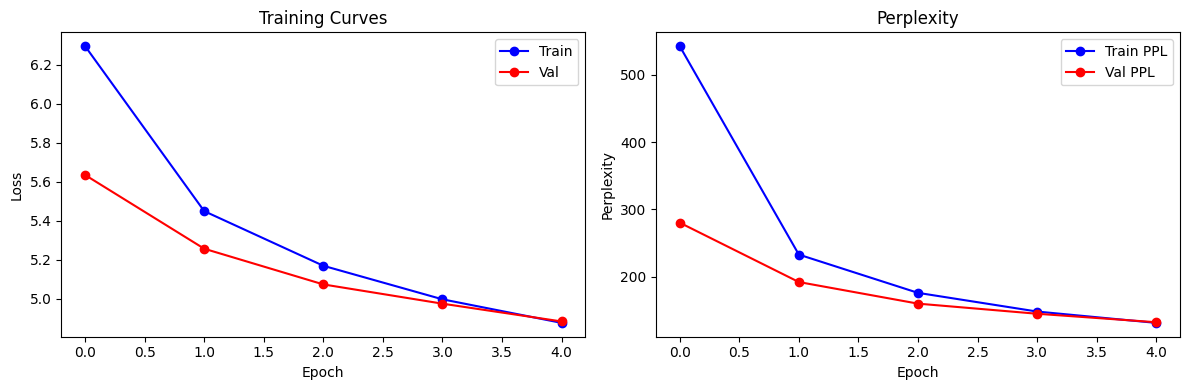


SAMPLE TRANSLATIONS
EN: Hello, how are you?
GU: “તમે કેવી રીતે છો?
----------------------------------------
EN: What is your name?
GU: નામ શું છે?
----------------------------------------
EN: I love learning languages.
GU: મને સંગીત ગમે છે.
----------------------------------------
EN: The weather is nice today.
GU: આ એક જ જગ્યાએ વાતાવરણમાં વધારો જોવા મળ્યો છે.
----------------------------------------
EN: Education is important.
GU: શિક્ષણનું મહત્ત્વ.
----------------------------------------
EN: India is a great country.
GU: ભારત એક મહાન દેશ છે.
----------------------------------------
EN: I am going to school.
GU: હું શાળાથી જ છું.
----------------------------------------
EN: Thank you very much.
GU: હું ખૂબ જ ખૂબ જ આભારી છું.
----------------------------------------

╔══════════════════════════════════════════════════════════╗
║  ENGLISH → GUJARATI TRANSLATION (FROM SCRATCH)          ║
╠══════════════════════════════════════════════════════════╣
║  Training: 285,000 samples, 5 epochs

In [29]:
# ══════════════════════════════════════════════════════════
# CELL 7: Final Summary & Sample Translations
# ══════════════════════════════════════════════════════════

# Plot training curves
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(train_losses, 'b-o', label='Train')
ax[0].plot(val_losses, 'r-o', label='Val')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].set_title('Training Curves')

ax[1].plot([math.exp(l) for l in train_losses], 'b-o', label='Train PPL')
ax[1].plot([math.exp(l) for l in val_losses], 'r-o', label='Val PPL')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Perplexity')
ax[1].legend()
ax[1].set_title('Perplexity')
plt.tight_layout()
plt.savefig('/kaggle/working/curves.png')
plt.show()

# Sample translations
print("\n" + "=" * 60)
print("SAMPLE TRANSLATIONS")
print("=" * 60)
samples = [
    "Hello, how are you?",
    "What is your name?",
    "I love learning languages.",
    "The weather is nice today.",
    "Education is important.",
    "India is a great country.",
    "I am going to school.",
    "Thank you very much."
]

for s in samples:
    translation = translate(model, s, en_sp, gu_sp)
    print(f"EN: {s}")
    print(f"GU: {translation}")
    print("-" * 40)

# Final summary
total_params = sum(p.numel() for p in model.parameters())
print(f"""
╔══════════════════════════════════════════════════════════╗
║  ENGLISH → GUJARATI TRANSLATION (FROM SCRATCH)          ║
╠══════════════════════════════════════════════════════════╣
║  Training: {len(train_en):,} samples, {NUM_EPOCHS} epochs                    ║
║  Model: {NUM_ENCODER_LAYERS}+{NUM_DECODER_LAYERS} layers, {D_MODEL}d, {total_params:,} params       ║
║  Best Val Loss: {best_val_loss:.4f}                                 ║
║  BLEU: {bleu.score:.2f}                                            ║
║  ROUGE-L: {avg_rougeL:.2f}                                         ║
╚══════════════════════════════════════════════════════════╝
Team: Rishit Laddha (2309575)
""")